In [1]:
import eval
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import train
import torchvision

/home/jpinkney/miniconda3/envs/clip2latent/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"
cfg_file = "best.yaml"
checkpoint = "best.ckpt"

cfg = OmegaConf.load(cfg_file)

G, clip_model, trainer = train.load_models(cfg, device)
trainer.load_state_dict(torch.load(checkpoint, map_location="cpu")["state_dict"], strict=False)
diffusion_prior = trainer.ema_diffusion_prior.ema_model

In [3]:
text_samples = "a photograph of boris johnson"
n_samples = 16
truncation = 1
cond_scale = 5
diffusion_prior.eval()
diffusion_prior.set_timestep_skip(100)
with torch.no_grad():
    text_features = clip_model.embed_text(text_samples)
    text_features = text_features.repeat_interleave(n_samples, dim=0)
    pred_w = diffusion_prior.sample(text_features, cond_scale=cond_scale, show_progress=True, truncation=truncation)
    images = G.synthesis(pred_w)
grid = torchvision.utils.make_grid(images.clamp(-1,1), nrow=4, value_range=(-1,1), normalize=True)
grid = 255*grid.permute(1,2,0).cpu()

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.11it/s]

Setting up PyTorch plugin "bias_act_plugin"... 

Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


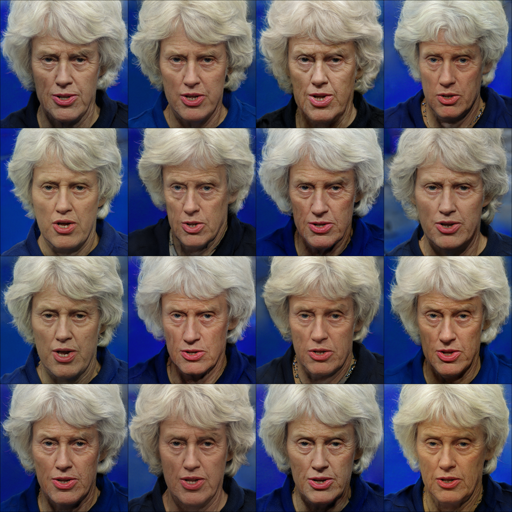

In [4]:
Image.fromarray(grid.numpy().astype(np.uint8)).resize((512,512))

1000it [04:19,  3.86it/s]


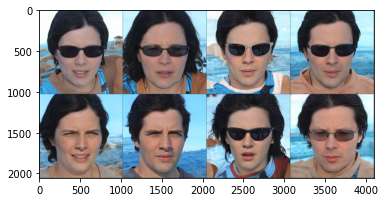

In [11]:
from joblib import Parallel, delayed
n_samples = 16
text_samples = "a photograph of a woman wearing sunglasses by the sea with long hair"
from clip2latent.train_utils import denormalise_data, normalise_data
truncation = 1
cond_scale = 1.0
plot_factor = 1
diffusion_prior.set_timestep_skip(1)
n_samples = 8
from tqdm import tqdm
from pathlib import Path
def save_im(im, f_name):
    Image.fromarray(im).save(f_name)
        
with Parallel(n_jobs=n_samples) as parallel:
    with torch.no_grad():
        text_features = clip_model.embed_text(text_samples)
        text_features = text_features.repeat_interleave(n_samples, dim=0)
        shape = (n_samples, 512)

        cond = {"text_embed": text_features}

        skip = diffusion_prior.skip_timesteps

        b = shape[0]
        image_embed = torch.randn(shape, device=device)
        loop = reversed(range(0, diffusion_prior.num_timesteps, skip))
        for idx, i in tqdm(enumerate(loop)):
            times = torch.full((b,), i, device = device, dtype = torch.long)
            latents = diffusion_prior.p_sample(image_embed, times, text_cond = cond, cond_scale = cond_scale)
            image_embed = latents.clone()

            if (idx % plot_factor == 0) or (idx == 999):
                # Denormalise
                latents = latents/diffusion_prior.image_embed_scale
                latents = denormalise_data(latents, diffusion_prior.latent_mean, diffusion_prior.latent_std)

                if truncation < 1.0:
                    print("truncation")
                    latents = diffusion_prior.latent_mean + truncation*(latents - diffusion_prior.latent_mean)

                # Reformat for StyleGAN
                if diffusion_prior.num_latents == 1:
                    latents = latents.unsqueeze(1)
                latent_repeats = torch.tensor(diffusion_prior.latent_repeats).to(torch.long).to(latents.device)
                latents = latents.repeat_interleave(latent_repeats, dim=1)
                out = G.synthesis(latents, noise_mode="const")
                images = 255*(out.clamp(-1,1)*0.5 + 0.5).permute(0, 2, 3, 1).cpu()
                images = images.numpy().astype(np.uint8)
                filenames = [f"progression/{sample_idx:02}/{idx:04}.jpg" for sample_idx in range(len(images))]
                
                [Path(x).parent.mkdir(exist_ok=True, parents=True) for x in filenames]
                
                parallel(delayed(save_im)(im, f_name) for im, f_name in zip(images, filenames))

grid = torchvision.utils.make_grid(out.clamp(-1,1), nrow=4, value_range=(-1,1), normalize=True)
grid = 255*grid.permute(1,2,0).cpu()
plt.imshow(grid.numpy().astype(np.uint8))
plt.show()

Image.fromarray(grid.numpy().astype(np.uint8)).save("progression/montage.jpg")

   

In [157]:
!mkdir progression

mkdir: cannot create directory ‘progression’: File exists


In [104]:
image_embed.shape

torch.Size([16, 1, 512])